In [1]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Add, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import pydot
from tensorflow.python.client import device_lib
import pathlib
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import random
import importlib

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
"""Data Augmentation"""

train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

dir='../datasets/based_dataset/Train'
train = train_data_gen.flow_from_directory(directory= dir,
                                           class_mode = 'categorical',
                                           shuffle='True',
                                           batch_size=64,
                                           target_size=(224,224))


Found 11825 images belonging to 3 classes.


In [4]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Test' , 
                                          target_size=(224,224), 
                                            class_mode = 'categorical',
                                        shuffle=False,
                                        batch_size=64)

valid = test_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Valid' , 
                                          target_size=(224,224), 
                                            class_mode = 'categorical',
                                        shuffle=False,
                                        batch_size=64)

Found 3698 images belonging to 3 classes.
Found 2956 images belonging to 3 classes.


In [5]:
basenet = keras.applications.densenet.DenseNet201(include_top=False,
                                                  weights='imagenet',
                                                  input_shape = (224,224,3))

In [6]:
for layer in basenet.layers:           
    layer.trainable = False

In [7]:
x = Flatten()(basenet.output)
d1 = Dense(1024, activation= 'relu')(x)
dr1 = Dropout(0.25)(d1)
d2 = Dense(1024, activation= 'relu')(dr1)
dr2 = Dropout(0.25)(d2)
prediction= Dense(units=3 , activation='softmax')(dr2)

model1 = Model(basenet.input,prediction)

In [8]:
model1.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [9]:

early = EarlyStopping(monitor='accuracy',patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience = 2,
                                            factor=0.3,
                                            min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]


In [10]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.7033995966580235, 1: 1.0246079195910234, 2: 0.695915725047081}


C:\Users\amara\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [11]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [12]:
hist = model1.fit(train, steps_per_epoch= len(train), epochs= 50, validation_data= valid,class_weight=cw,validation_steps= len(test), callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
185/185 [==============================] - 148s 713ms/step - loss: 2.6286 - accuracy: 0.6932 - val_loss: 0.5126 - val_accuracy: 0.8099
Epoch 2/50
185/185 [==============================] - 123s 662ms/step - loss: 0.6074 - accuracy: 0.7733
Epoch 3/50
185/185 [==============================] - 123s 662ms/step - loss: 0.5944 - accuracy: 0.7892
Epoch 4/50
185/185 [==============================] - 126s 679ms/step - loss: 0.5588 - accuracy: 0.8010
Epoch 5/50
185/185 [==============================] - 173s 932ms/step - loss: 0.5466 - accuracy: 0.8064
Epoch 6/50
185/185 [==============================] - 281s 2s/step - loss: 0.5283 - accuracy: 0.8101
Epoch 7/50
185/185 [==============================] - 281s 2s/step - loss: 0.5042 - accuracy: 0.8173
Epoch 8/50
185/185 [==============================] - 281s 2s/step - loss: 0.4965 - accuracy: 0.82

In [13]:
model1.evaluate(test)

58/58 [==============================] - 96s 2s/step - loss: 0.3162 - accuracy: 0.8913


[0.3162061870098114, 0.8912925720214844]

In [14]:
preds = model1.predict(test,verbose=1)

58/58 [==============================] - 83s 1s/step


In [15]:
predictions = np.argmax(preds, axis = -1)

In [16]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','COVID', 'Lung Opacity']))

              precision    recall  f1-score   support

      NORMAL       0.89      0.85      0.87       724
       COVID       0.87      0.89      0.88      1203
Lung Opacity       0.91      0.91      0.91      1771

    accuracy                           0.89      3698
   macro avg       0.89      0.88      0.89      3698
weighted avg       0.89      0.89      0.89      3698



<AxesSubplot:>

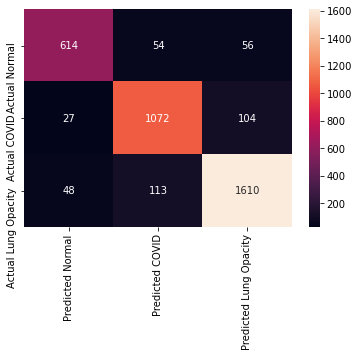

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions),index=["Actual Normal", "Actual COVID", "Actual Lung Opacity"],
columns=["Predicted Normal", "Predicted COVID","Predicted Lung Opacity"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [18]:
y_true=test.classes

In [19]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns

**Overall Results**
Accuracy Result: 89.13%
Precision Result: 86.52%
Recall Result: 89.11%
F-Score Result: 87.80%


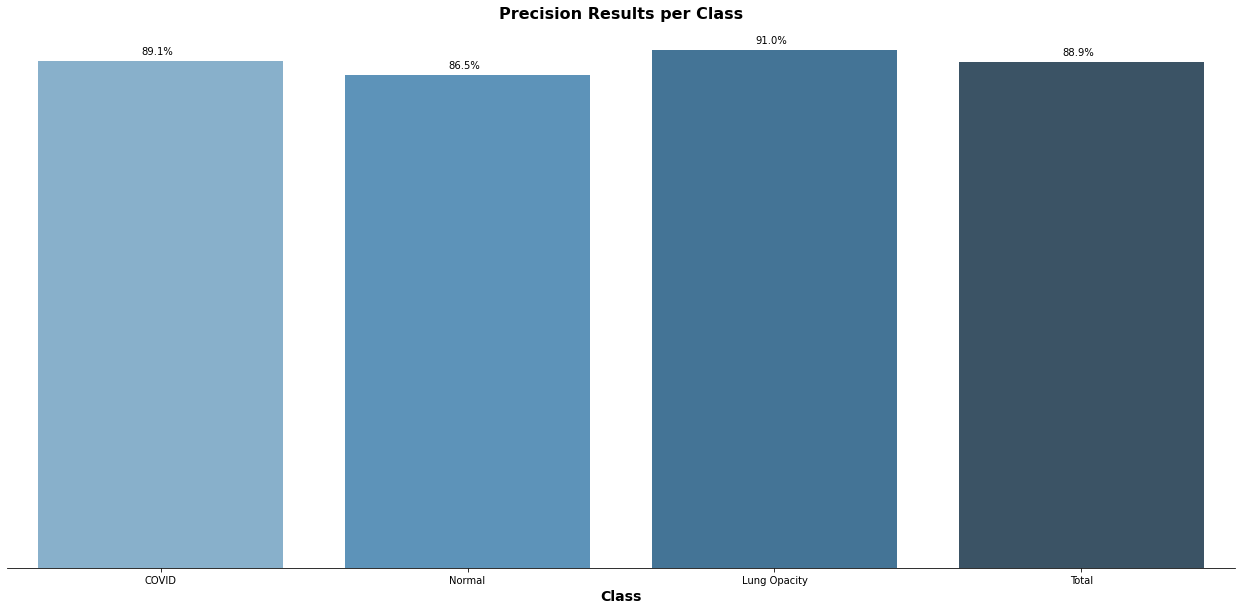

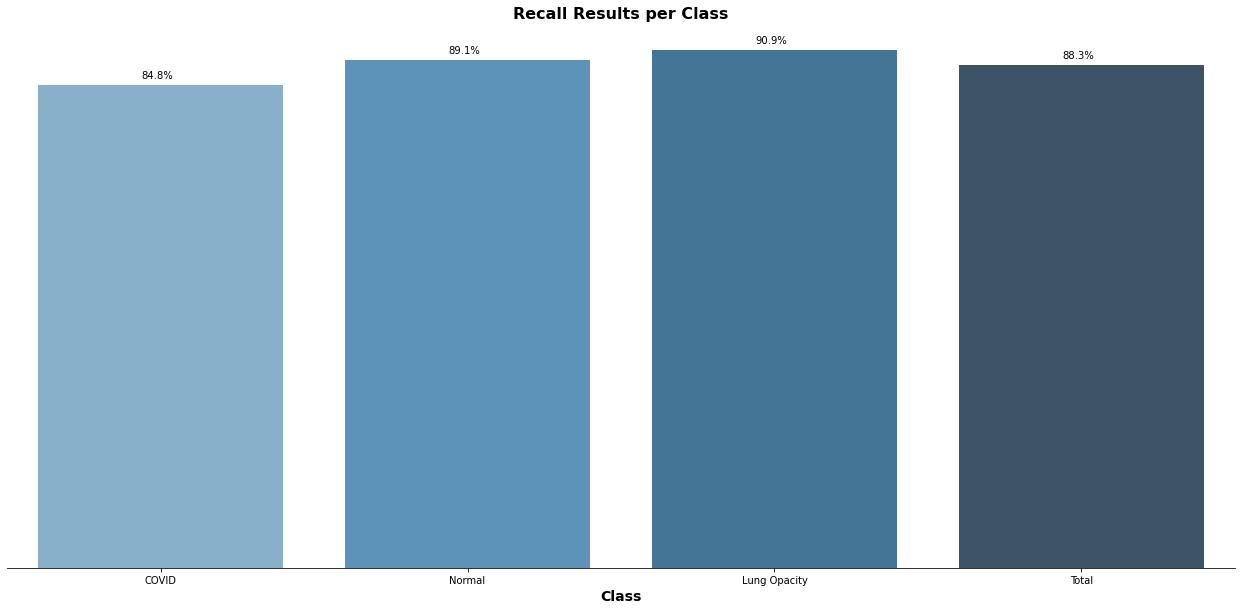

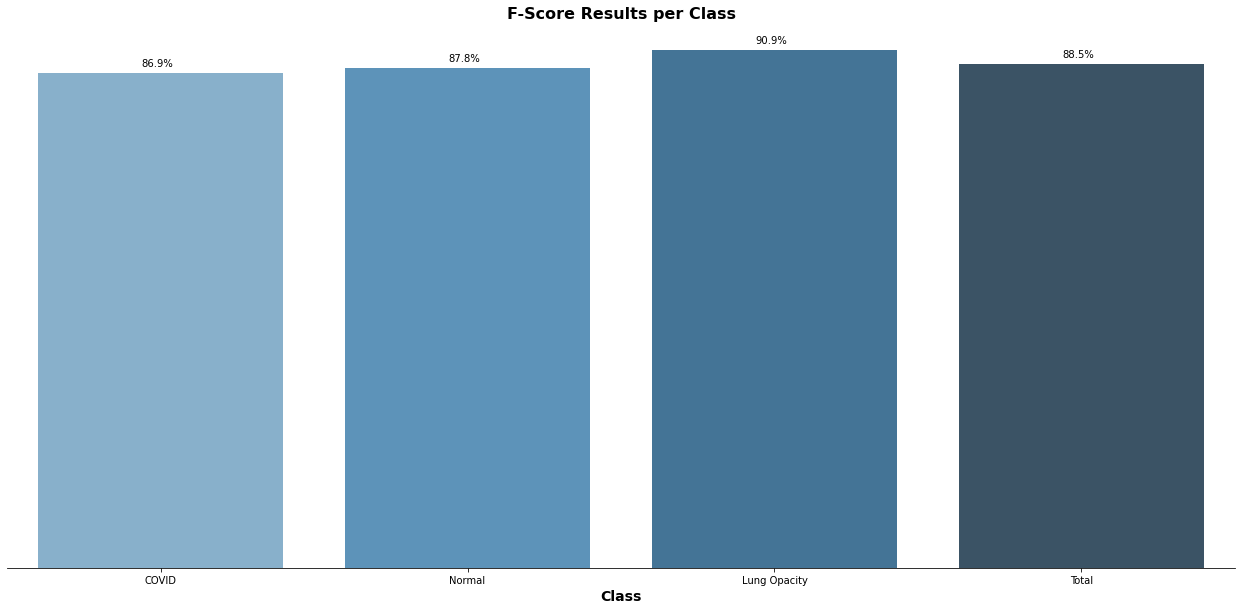

In [20]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal','Lung Opacity','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset